In [1]:
from pandas import DataFrame, read_excel
import matplotlib.pyplot as plt
import pandas as pd 
import os


class XML_Stats():
    _counter = 0

    # file_paths contains one elem - original location or several elements - blending of several data sources
    def __init__(self, file_paths, df = None):
        XML_Stats._counter += 1
        self.id = XML_Stats._counter
        
        self.file_paths = file_paths
        if len(file_paths) == 1:
            self.df = self.read_data()
        else:
            if df is None:
                raise Exception('dataframe of XML_Stats can not be None!')
            self.df = df
        
    def read_data(self):
        return pd.read_excel(self.file_paths[0])
    
    def get_columns_amount(self):
        return len(self.get_columns())
    
    def get_columns(self):
        return self.df.columns.values.tolist()
        
    def get_lines_amount(self):
        return dict(self.df.count())['S.No.']
        
    def write_to_csv(self, dir_to, file_name='cleared_merged_data.csv'):
        file_path = os.path.join(dir_to, file_name)
        self.df.to_csv(file_path, encoding='utf-8', index=False)
        
    def get_dataframe(self):
        return self.df
    
    def are_mergable(self, xmlstats_obj):
        col1 = self.get_columns()
        col2 = xmlstats_obj.get_columns()
        for c in col1:
            if c not in col2 or self.df[c].dtype != xmlstats_obj.df[c].dtype:
                return False
        return True

    def get_possible_merging_problems(self, xmlstats_obj):
        str_res = self.file_paths[0] + ' +\n' + xmlstats_obj.file_paths[0] + '\n'
        col1 = self.get_columns()
        col2 = xmlstats_obj.get_columns()
        errors = 0
        for c in col1:
            if c not in col2 or self.df[c].dtype != xmlstats_obj.df[c].dtype:
                errors += 1
                if c not in col2:
                    str_res += 'problem: column ' + c + ' does not exist\n'
                else:
                    str_res += 'problem: columns with the same name ' + c + f' have different types: {self.df[c].dtype}, {xmlstats_obj.df[c].dtype}\n'
        if errors == 0:
            str_res += 'Can be merged!\n'
        return str_res, errors==0
        
    
    def merge_xmlstats_objects(self, xmlstats_obj):
        if not self.are_mergable(xmlstats_obj):
            raise Exception('Can not merge xmlstats objects!')
        combined_file_paths = self.file_paths + xmlstats_obj.file_paths
        return XML_Stats(combined_file_paths, df=pd.concat([self.df, xmlstats_obj.df]))
    
    def count_values_in_columns(self):
        value_counts = dict(self.df.count())
        return [(name, value_counts[name]) for name in (sorted(value_counts, key=value_counts.get, reverse=True))]
         
    def delete_0_value_columns(self):
        """
        let's delete columns with 0 values ('US Price/Litre', '0/5117')
        """
        res = self.count_values_in_columns()
        need_to_delete = []
        for column in reversed(res):
            name, value = column[0], column[1]
            if value != 0:
                break
            need_to_delete.append(name)
        self.delete_columns(need_to_delete)
        
    # column_names - list of columns names which need to be deleted
    def delete_columns(self, column_names):
        self.df = self.df.drop(columns=column_names, axis=1, errors='ignore')
        
    def get_unique_values(self):
        res = {}
        for c in self.get_columns():
            uniques = self.df[c].unique().tolist()
            res[c] = (len(uniques), uniques)
        return [(name, res[name]) for name in (sorted(res, key=lambda a: res[a][0], reverse=True))]
    
    def get_unique_values_stats(self):
        str_res = ''
        uniques = self.get_unique_values()
        for u, val in uniques:
            if len(val[1]) > 12:
                str_res += f'{(u, val[0])}\n'
            else:
                str_res += f'{(u, val[0], val[1])}\n'
        return str_res
    
    def get_not_nan_values_stats(self):
        str_res = ''
        non_nan_values = self.count_values_in_columns()
        ids = str(self.get_lines_amount())
        for u, val in non_nan_values:
            second_param = str(val)+'/'+ids
            str_res += f'{(u, second_param)}\n'
        return str_res
        
    def __str__(self):
        return f'file paths: {self.file_paths}, \nnumber of columns: {self.get_columns_amount()}, \nnumber of lines: {self.get_lines_amount()}'
        
        

In [54]:
from functools import reduce
import pathlib
import yaml
import re
import string
import sys
import numpy as np

def get_config():
    with open("config.yaml", 'r') as stream:
        config = yaml.safe_load(stream)
    return config

def read_xml_objects(file_dir, file_names):
    return [XML_Stats([os.path.join(file_dir, file_name)]) for file_name in file_names]
    
def write_statistics_to_file(xmlstats_obj, dir_to, file_path=''):
    if file_path == '':
        file_path = os.path.join(dir_to, pathlib.PurePath(xmlstats_obj.file_paths[0]).name + '.txt')
    else:
        file_path = os.path.join(dir_to, file_path)
    print('print statistics to txt file:', file_path)
    
    with open(file_path, 'w') as f:
        f.write('\nCommon info:\n' + str(xmlstats_obj) + '\n')
        f.write('\nNumber of unique values per column (uniques values are shown if their amount is less than 12)\n' + xmlstats_obj.get_unique_values_stats())
        f.write('\nNumber of non nan values per column\n' + xmlstats_obj.get_not_nan_values_stats())
        
def write_possible_merging_problems(problems, dir_to):
    file_path = os.path.join(dir_to, 'merge_problems.txt')
    print('print merging problems to txt file:', file_path)
    with open(file_path, 'w') as f:
        for line in problems:
            f.write('\n'+line[0]+'\n')
    return file_path   
    
def merge_xmlstats_objs(xmlstats_objs):
    return reduce(lambda obj1, obj2: obj1.merge_xmlstats_objects(obj2), xmlstats_objs)

def split_to_list(row):
    return row.replace(';', ',')
    
    
def check_flavor_column(obj):
    column_name = 'Flavor'
    obj.df[column_name] = obj.df[column_name].fillna('')
    obj.df[column_name] = obj.df[column_name].apply(lambda row: split_to_list(str(row)))
    obj.df[column_name] = obj.df[column_name].astype('string')
    
def clean_string(row):
    row = ''.join(filter(lambda x:x in string.printable, row))
    row = re.sub('[\s+`+*+\r+\n+\\\\+~|^$]', ' ', row)
    row = row.replace('\\r', ' ')
    row = row.replace('\\n', ' ')
    return row
    
def clean_string_columns(obj, column_name):
    p = re.compile('[\w\s\-&.,/!:;+?_\'%\\(){}\"<>=\[\]]*')
    obj.df[column_name] = obj.df[column_name].fillna('')
    obj.df[column_name] = obj.df[column_name].apply(lambda row: clean_string(str(row)))
    for val in list(obj.df[column_name]):
        if not p.fullmatch(val):
            raise Exception('Following structure does not meet predifined metadata: ', val, ' in column ', column_name)
    obj.df[column_name] = obj.df[column_name].astype('string')
    
def clean_float64(row, p):
    res = p.findall(str(row))
    if len(res) > 0:
        return res[0]
    # if the value was nan we return nan, not 0.0 (interpolation may be needed)
    return row
#     return 0.0
    
def clean_float64_columns(obj, column_name):
    p = re.compile(r"[-+]?(?:\d*\.*\d+)")
    obj.df[column_name] = obj.df[column_name].apply(lambda row: clean_float64(row, p))
    obj.df[column_name] = pd.to_numeric(obj.df[column_name])
    
    
def clean_int64(row):
    res = re.findall(r'\d+', str(row))
    if len(res) > 0:
        return res[0]
    # if the value was nan we return nan, not 0 (interpolation may be needed)
    return row
    
def clean_int64_columns(obj, column_name):
    obj.df[column_name] = obj.df[column_name].apply(lambda row: clean_int64(row))
    obj.df[column_name] = obj.df[column_name].astype('int')
    
    
def clean_data(obj, metadata):
    for column, data_type in metadata.items():
        # in case the metadata field in config contains column names which don't exist
        if column in obj.df.columns:
            if data_type == 'string':
                clean_string_columns(obj, column)
            elif data_type == 'float64':
                clean_float64_columns(obj, column)
            else:
                clean_int64_columns(obj, column)

                
new_xmlstats_obj = None

def main():
    config = get_config()
    file_dir = config['directory_from']
    file_names = config['file_paths']
    delete_columns = config['delete_columns']
    dir_to = config['directory_to']
    metadata = config['metadata']
    
    #read all files
    xmlstats_objs = read_xml_objects(file_dir, file_names)
    
    #clear a bit
    for obj in xmlstats_objs:
#         obj.delete_0_value_columns()
        obj.delete_columns(delete_columns)
        check_flavor_column(obj)
        clean_data(obj, metadata)
        write_statistics_to_file(obj, dir_to)
        
    problems_info = [xmlstats_objs[i].get_possible_merging_problems(xmlstats_objs[i+1]) for i in range(len(xmlstats_objs)-1)]
    file_path = write_possible_merging_problems(problems_info, dir_to)
    for problem in problems_info:
        if not problem[1]:
            raise Exception('Check ' + file_path + ' file! Data sources can not be merged')

    # merge all files into one
    global new_xmlstats_obj
    new_xmlstats_obj = merge_xmlstats_objs(xmlstats_objs)
    write_statistics_to_file(new_xmlstats_obj, dir_to, file_path='cleared_merged_data_stats.txt')
    new_xmlstats_obj.write_to_csv(dir_to)
    
    
    
main()

print statistics to txt file: /commons/dsls/fine_bakery/stats_results/2020-2022 BAK Bread__Bread_products_WE1 (5200).xls.txt
print statistics to txt file: /commons/dsls/fine_bakery/stats_results/2020-2022 BAK Bread__Bread_products_WE2 (2100).xls.txt
print statistics to txt file: /commons/dsls/fine_bakery/stats_results/2020-2022_BAK Cakes&Sweet_Goods_WE1 (8300).xls.txt
print statistics to txt file: /commons/dsls/fine_bakery/stats_results/2020-2022_BAK Cakes&Sweet_Goods_WE2 (4800).xls.txt
print statistics to txt file: /commons/dsls/fine_bakery/stats_results/2020-2022_BAK DataBase EE (5800).xls.txt
print statistics to txt file: /commons/dsls/fine_bakery/stats_results/2020-2022_BAK Savoury_Biscuits WE (4250).xlsx.txt
print statistics to txt file: /commons/dsls/fine_bakery/stats_results/2020-2022_BAK Sweet_biscuits_cookies_WE1 (5000).xls.txt
print statistics to txt file: /commons/dsls/fine_bakery/stats_results/2020-2022_BAK Sweet_biscuits_cookies_WE2 (5000).xls.txt
print statistics to txt f

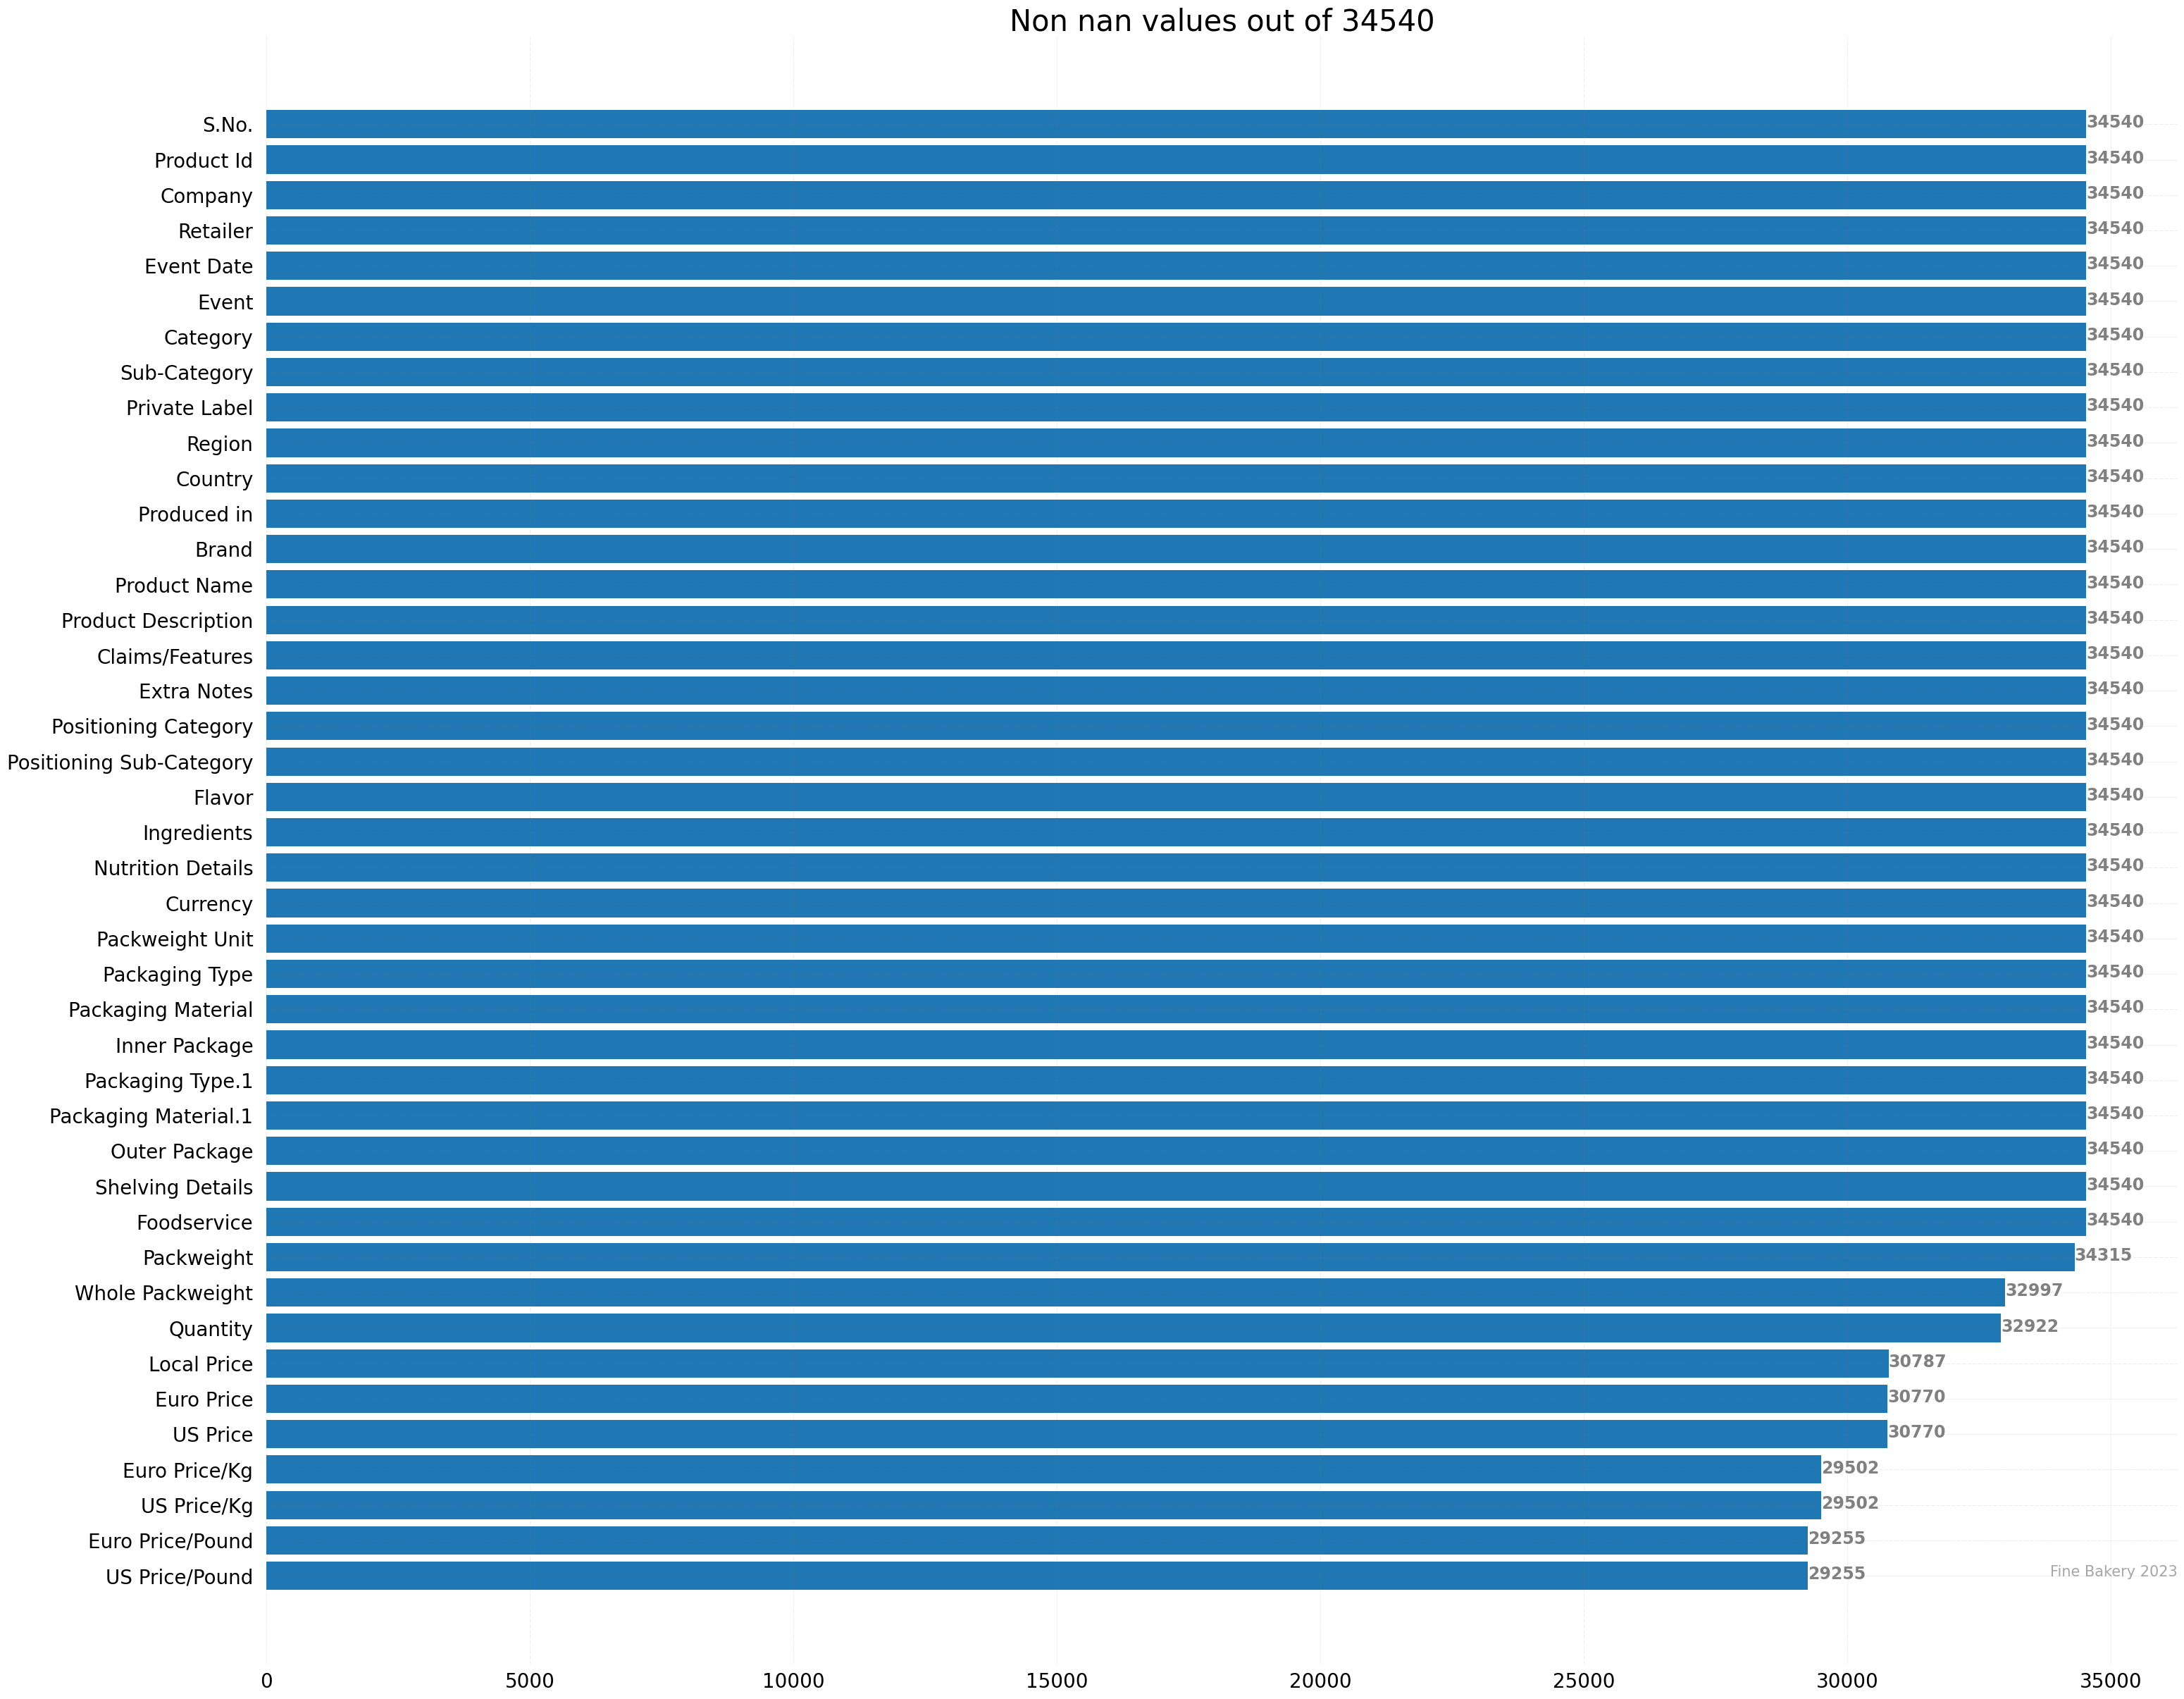

In [55]:
def create_plot_of_non_nan_values(obj):
    non_nan_values = obj.count_values_in_columns()
    x = [pair[0] for pair in non_nan_values]
    y = [pair[1] for pair in non_nan_values]
    ids = str(obj.get_lines_amount())
    
    fig, ax = plt.subplots(figsize =(35, 30))
    ax.barh(x, y)

    for s in ['top', 'bottom', 'left', 'right']:
        ax.spines[s].set_visible(False)

    ax.xaxis.set_ticks_position('none')
    ax.yaxis.set_ticks_position('none')

    ax.xaxis.set_tick_params(pad = 5)
    ax.yaxis.set_tick_params(pad = 10)
    plt.xticks(fontsize = 20)
    plt.yticks(fontsize = 20)

    ax.grid(color ='grey', linestyle ='-.', linewidth = 0.5, alpha = 0.2)
    ax.invert_yaxis()

    # Add annotation to bars
    for i in ax.patches:
        plt.text(i.get_width()+0.2, i.get_y()+0.5,
                 str(round((i.get_width()), 2)),
                 fontsize = 17, fontweight ='bold',
                 color ='grey')
    
    ax.set_title("Non nan values out of " + str(ids), fontsize = 30)
    fig.text(0.9, 0.15, 'Fine Bakery 2023', fontsize = 15,
             color ='grey', ha ='right', va ='bottom',
             alpha = 0.7)
    plt.show()
 

create_plot_of_non_nan_values(new_xmlstats_obj)

[nltk_data] Downloading package stopwords to
[nltk_data]     /homes/asorova/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


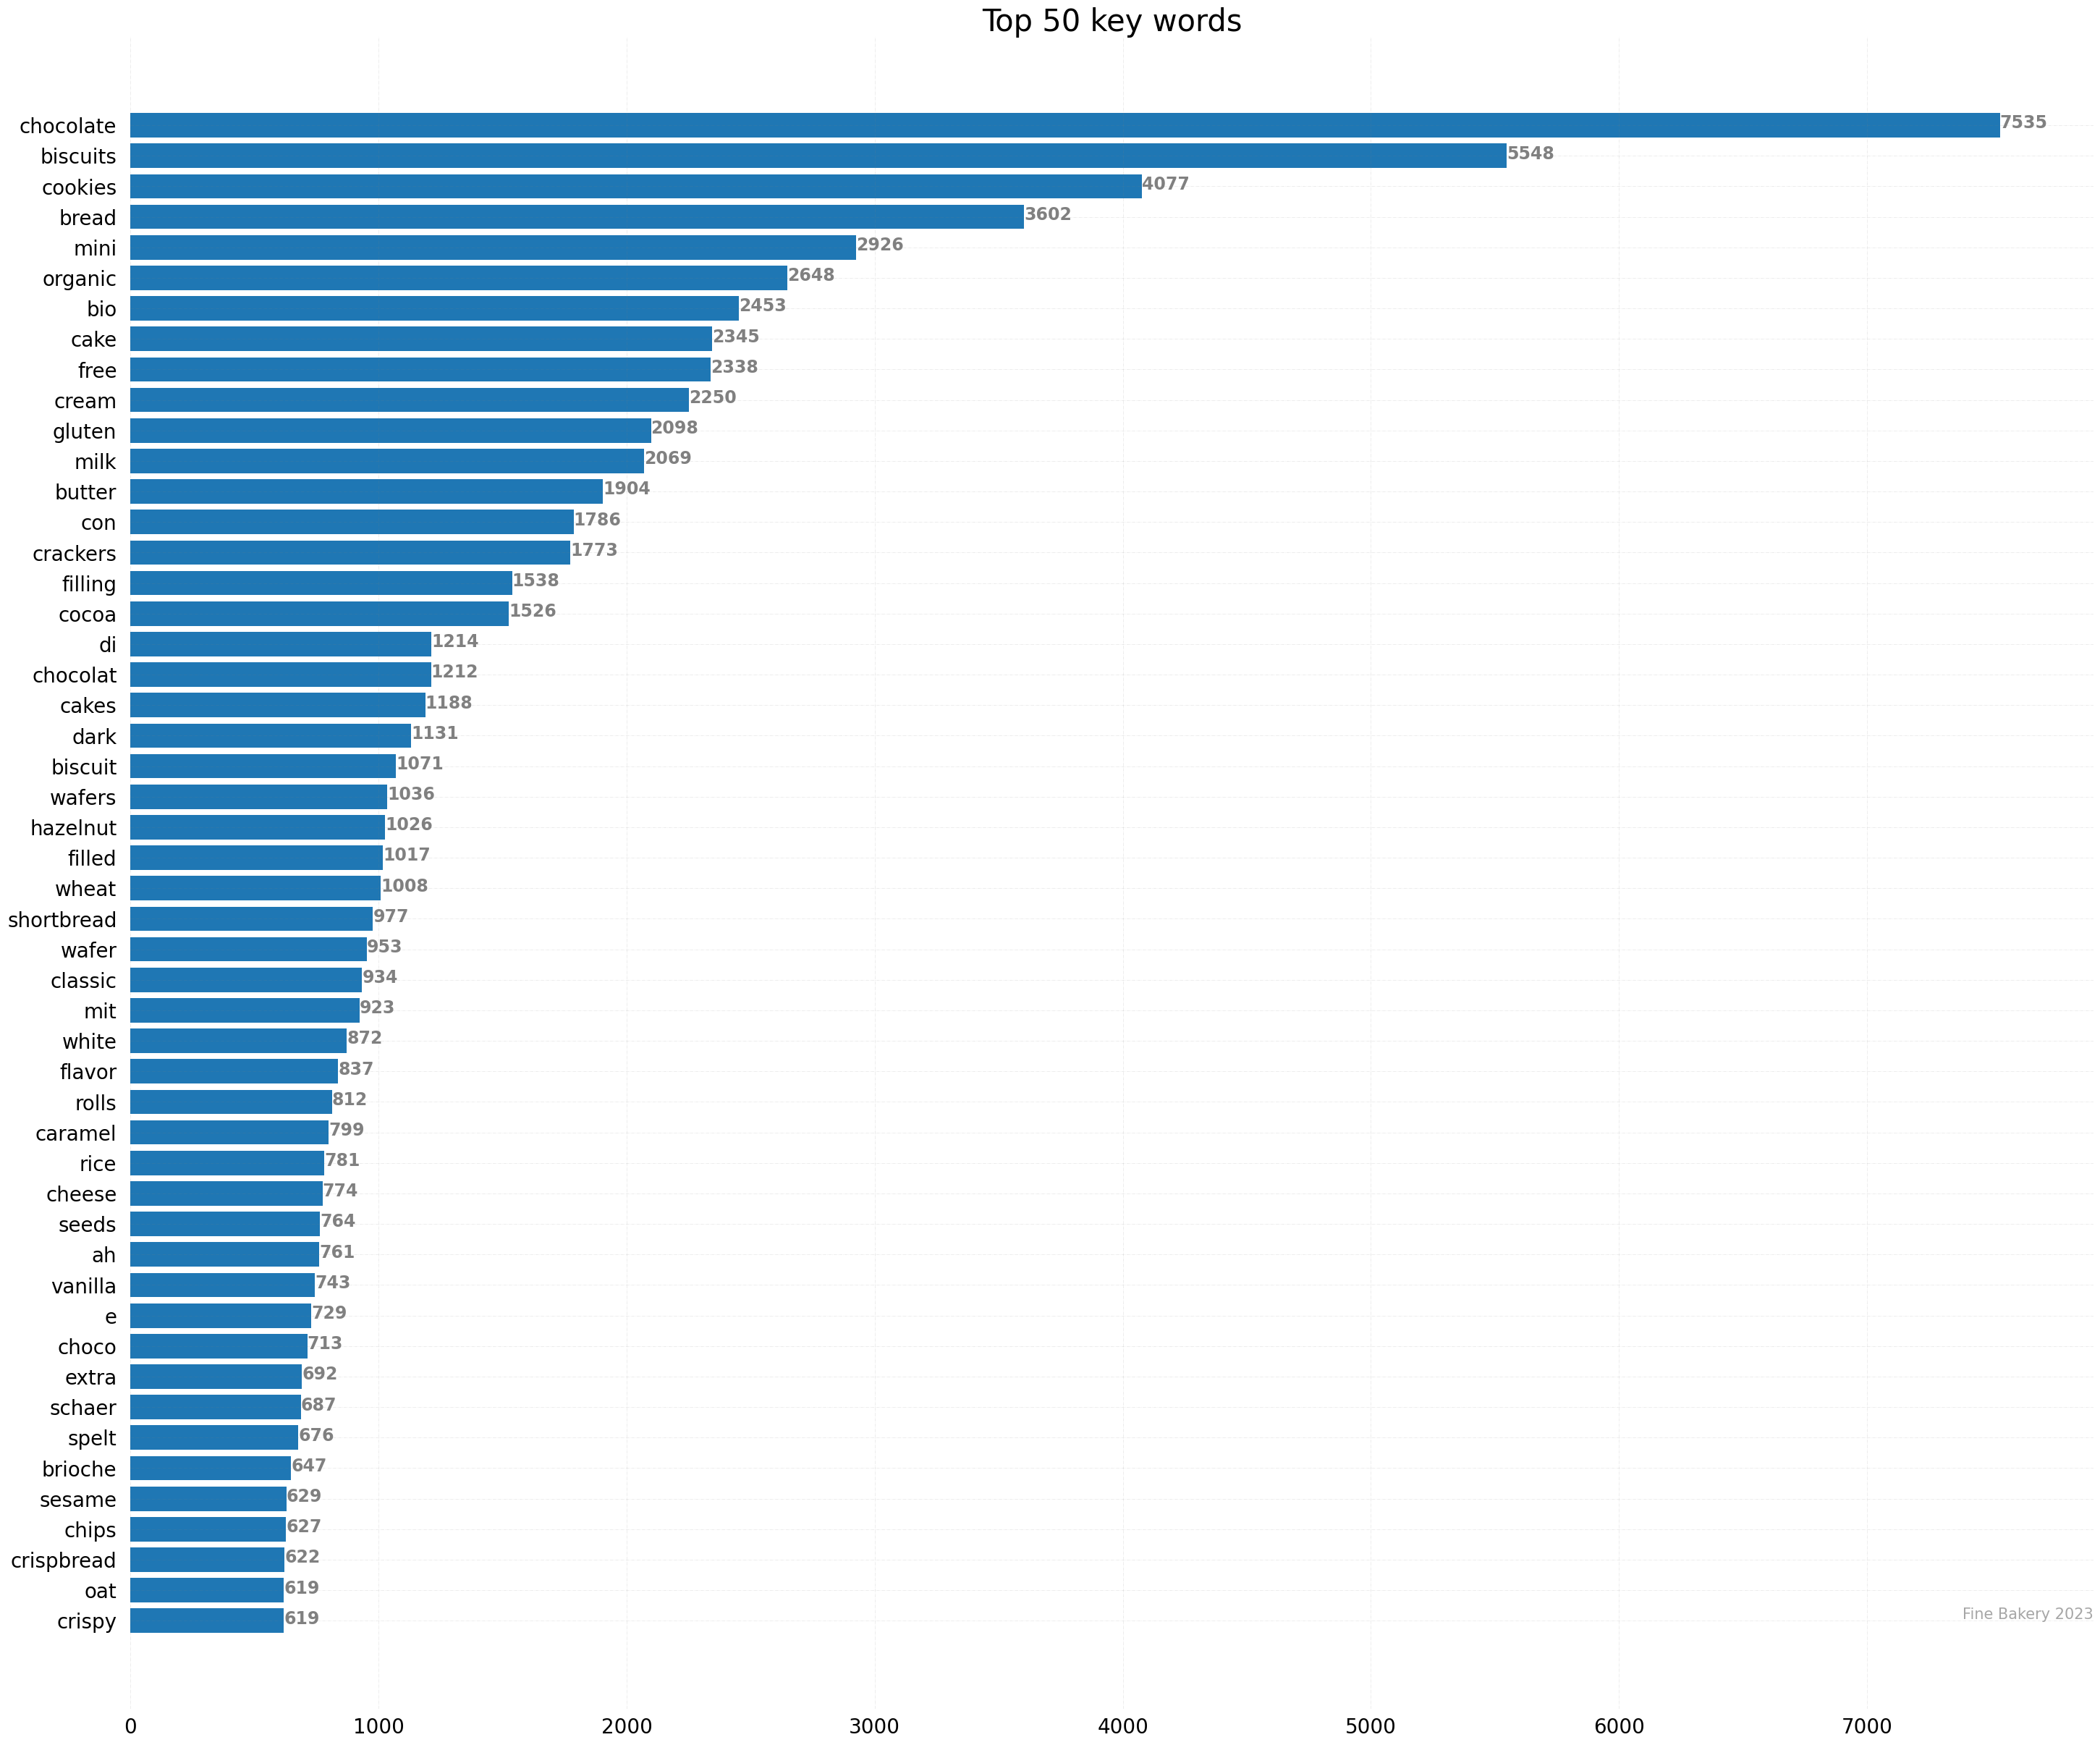

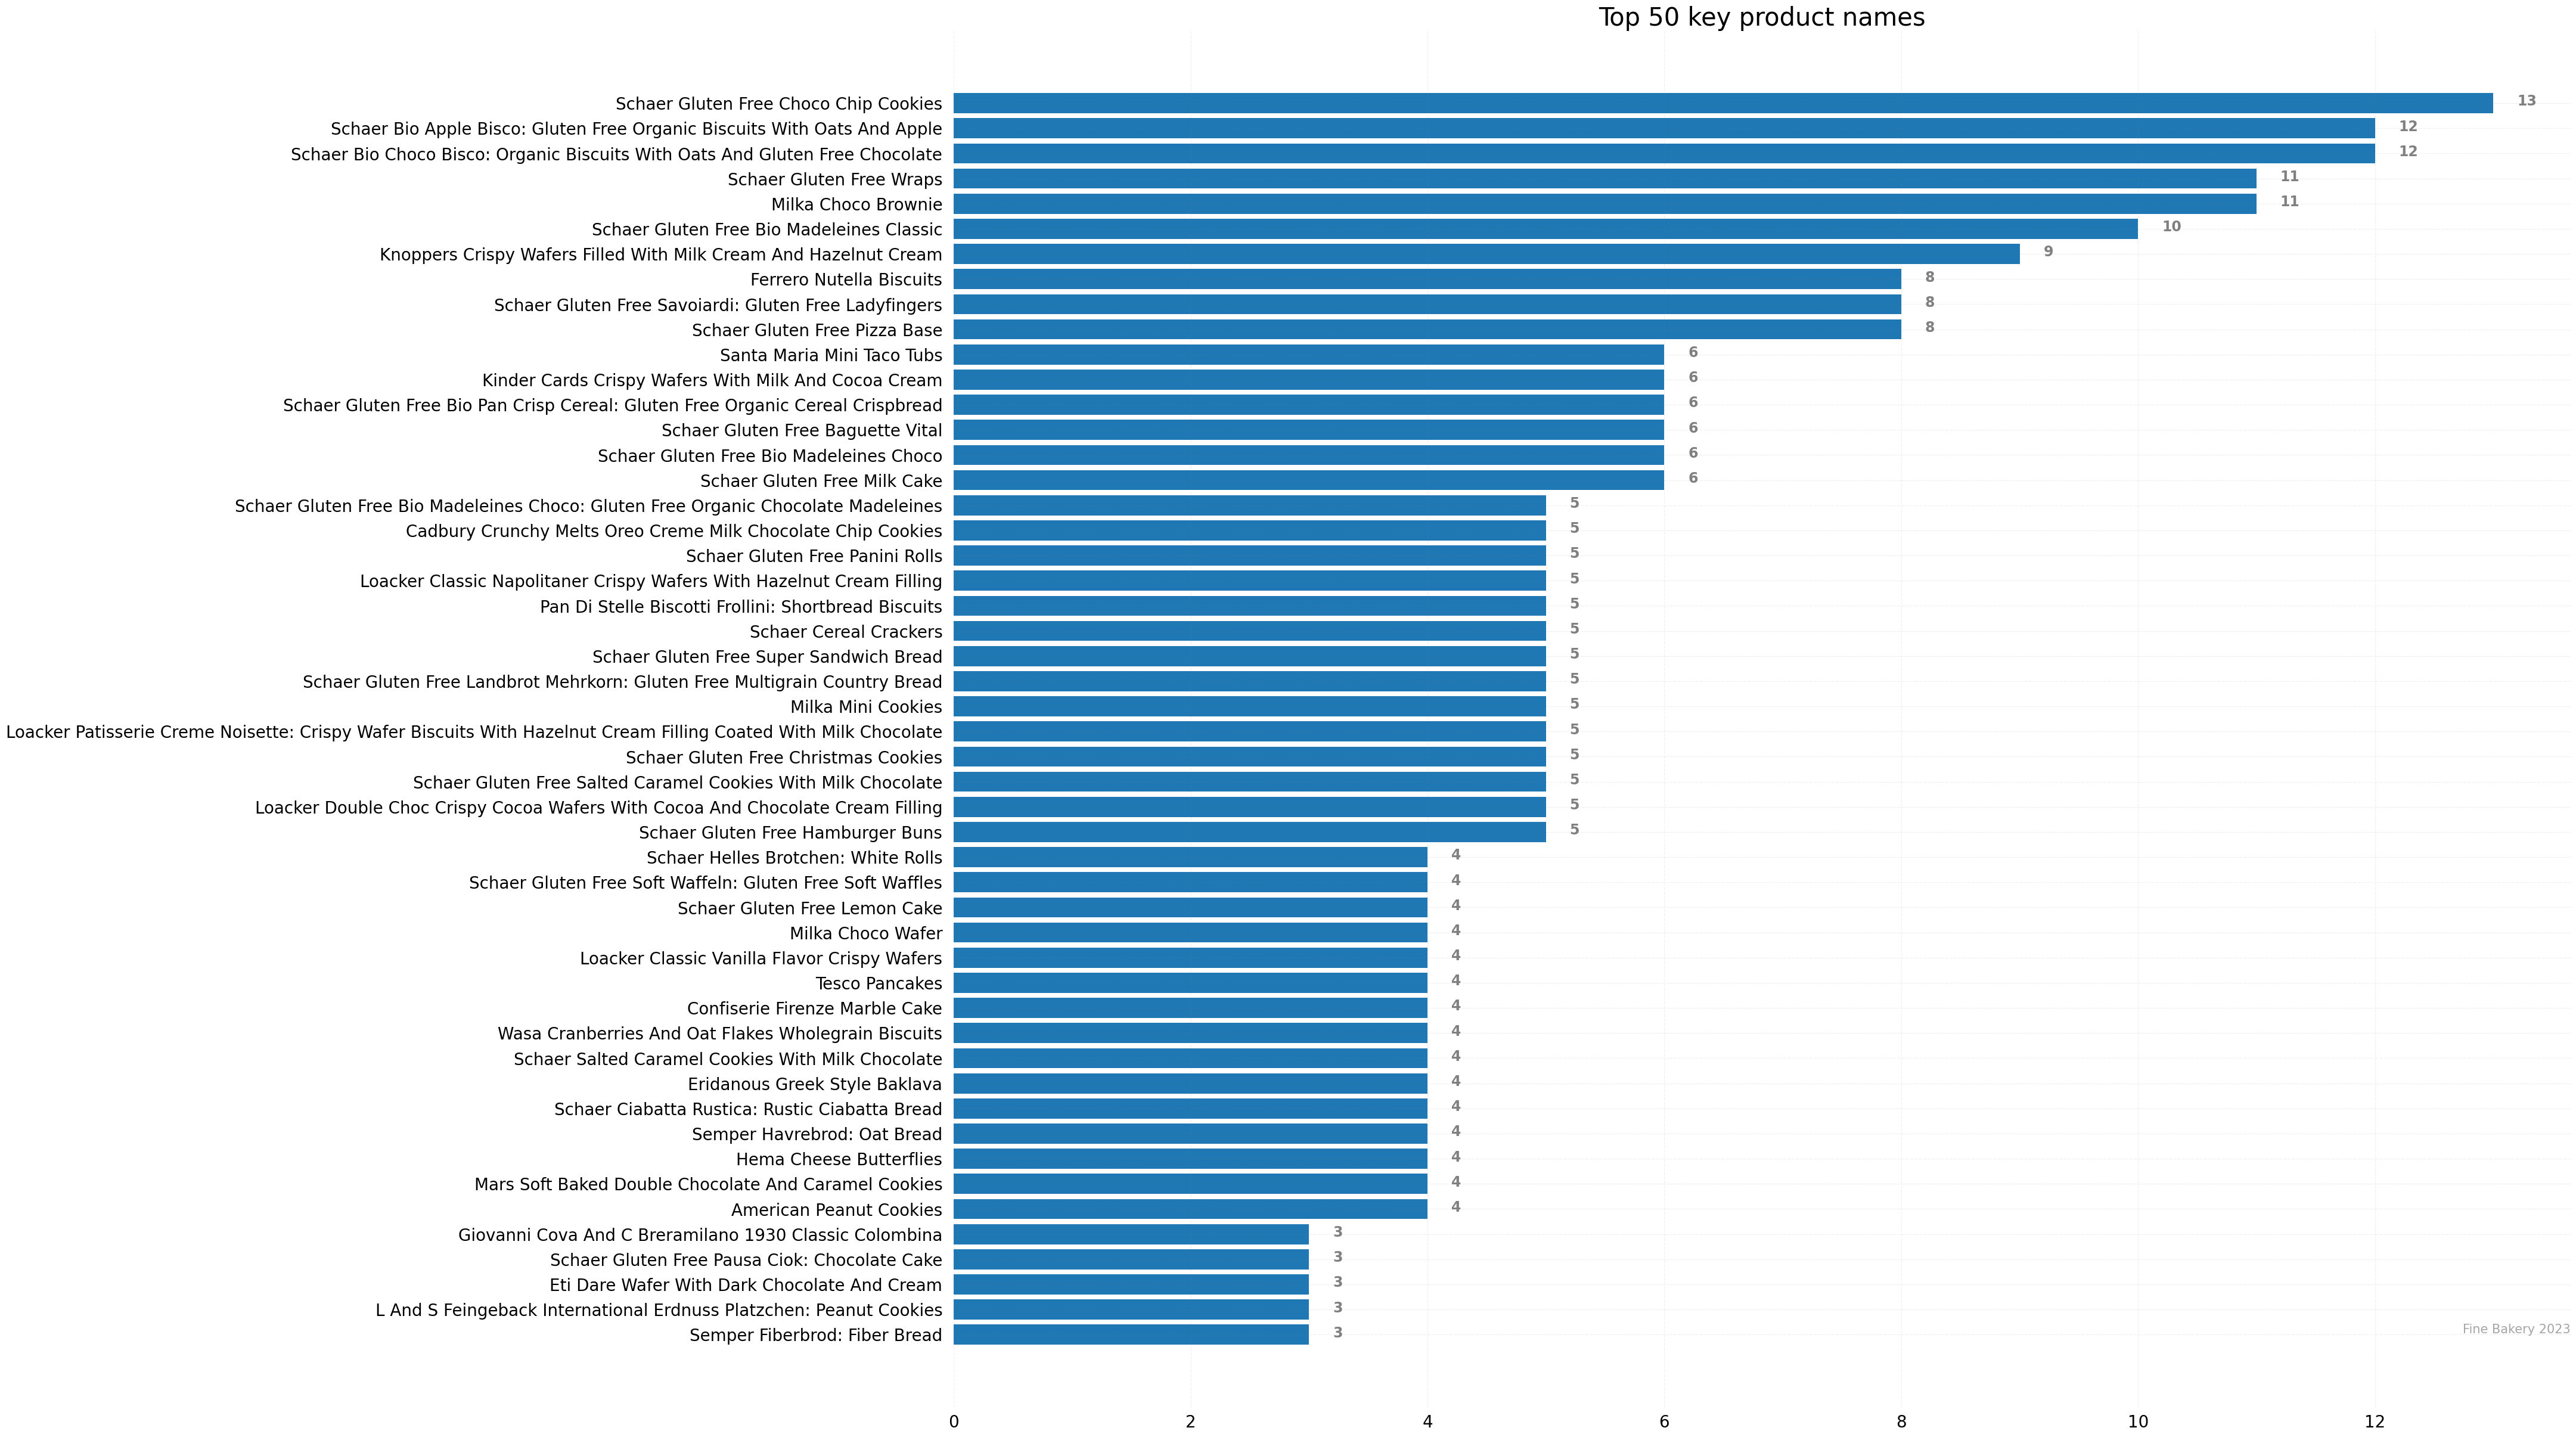

In [106]:
from collections import Counter
from nltk.corpus import stopwords
import nltk
nltk.download('stopwords')

stop_words = set(stopwords.words('english')).union(set(stopwords.words('french')))

def get_key_words_from_product_name(obj, top_amount):
    words = []
    for product in obj.df['Product Name']:
        product = product.lower()
        found_words = re.findall(r'\w+', product)
        words += [w for w in found_words if w not in stop_words]
    return Counter(words).most_common(top_amount)

def get_key_product_names(obj, top_amount):
    return dict(obj.df['Product Name'].value_counts().nlargest(top_amount))

res1 = get_key_words_from_product_name(new_xmlstats_obj, 50)
# print(res1)

res2 = get_key_product_names(new_xmlstats_obj, 50)
# print(res2)

def create_plot(x, y, title):
    
    fig, ax = plt.subplots(figsize =(35, 30))
    ax.barh(x, y)

    for s in ['top', 'bottom', 'left', 'right']:
        ax.spines[s].set_visible(False)

    ax.xaxis.set_ticks_position('none')
    ax.yaxis.set_ticks_position('none')

    ax.xaxis.set_tick_params(pad = 5)
    ax.yaxis.set_tick_params(pad = 10)
    plt.xticks(fontsize = 20)
    plt.yticks(fontsize = 20)

    ax.grid(color ='grey', linestyle ='-.', linewidth = 0.5, alpha = 0.2)
    ax.invert_yaxis()

    # Add annotation to bars
    for i in ax.patches:
        plt.text(i.get_width()+0.2, i.get_y()+0.5,
                 str(round((i.get_width()), 2)),
                 fontsize = 17, fontweight ='bold',
                 color ='grey')
    
    ax.set_title(title, fontsize = 30)
    fig.text(0.9, 0.15, 'Fine Bakery 2023', fontsize = 15,
             color ='grey', ha ='right', va ='bottom',
             alpha = 0.7)
    plt.show()
    
x = [pair[0] for pair in res1]
y = [pair[1] for pair in res1]
create_plot(x, y, "Top 50 key words")

create_plot(list(res2.keys()), list(res2.values()), "Top 50 key product names") 
